# ECSE 415 Assignment 2, Question 3
### Alex Hale | 260672475 | October 20, 2019

## Object Detection
### Step 1 - Training

In [1]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
import imutils

In [2]:
# compute the Histogram of Gradients of the supplied image
# return a vector of HoG features
def hog(img, cell_size_h=4, cell_size_w=4, block_size_h=2, block_size_w=2, orient_bins=9):
    cell_size = (cell_size_h, cell_size_w)  # h x w in pixels
    block_size = (block_size_h, block_size_w)  # h x w in cells
    nbins = orient_bins  # number of orientation bins
    
    hog = cv2.HOGDescriptor(_winSize=(img.shape[1] // cell_size[1] * cell_size[1],
                                      img.shape[0] // cell_size[0] * cell_size[0]),
                            _blockSize=(block_size[1] * cell_size[1],
                                        block_size[0] * cell_size[0]),
                            _blockStride=(cell_size[1], cell_size[0]),
                            _cellSize=(cell_size[1], cell_size[0]),
                            _nbins=nbins)

    n_cells = (img.shape[0] // cell_size[0], img.shape[1] // cell_size[1])

    # Compute HoG features
    hog_feats = hog.compute(img) \
                   .reshape(n_cells[1] - block_size[1] + 1,
                            n_cells[0] - block_size[0] + 1,
                            block_size[1], block_size[0], nbins) \
                   .transpose((1, 0, 3, 2, 4))  # index blocks by rows first
    
    return (hog_feats)

# compute the space-scale pyramid for the supplied image
    # scale = how much the image is resized at each layer of the pyramid
    # minSize = minimum height and width of a layer - when the image falls below this size, layers will no longer be computed
def pyramid(image, scale=1.5, minSize=(30, 30)):
    # yield the original image
    yield image
 
    # keep looping over the pyramid
    while True:
        # compute the new dimensions of the image and resize it
        w = int(image.shape[1] / scale)
        image = imutils.resize(image, width=w)

        # if the resized image does not meet the supplied minimum
        # size, then stop constructing the pyramid
        if image.shape[0] < minSize[1] or image.shape[1] < minSize[0]:
            break

        # yield the next image in the pyramid
        yield image
        
# compute the various window locations for sliding-window execution
    # stepSize = how many pixels the window should move on each step (aka "stride")
    # windowSize = size of the window we're sliding around
def sliding_window(image, stepSize, windowSize):
    for y in range(0, image.shape[0], stepSize):
        for x in range(0, image.shape[1], stepSize):
            yield (x, y, image[y:y + windowSize[1], x:x + windowSize[0]])

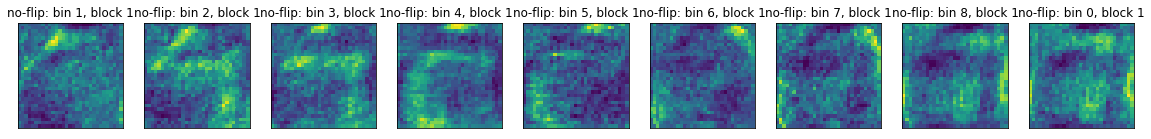

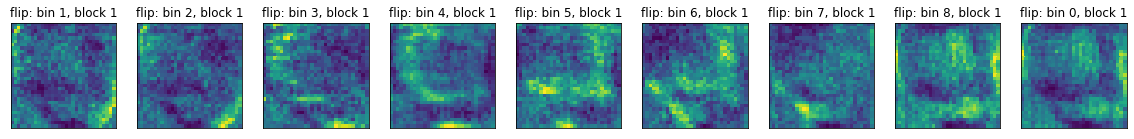

In [3]:
cars = []
cars_flipped = []
feat_vecs = []
feat_vecs_flipped = []

# import and execute HoG on each training image
for i in range(14):
    cars.append(cv2.cvtColor(cv2.imread("car" + str(i+1) + ".jpg"), cv2.COLOR_BGR2GRAY))
    cars[i] = cv2.resize(cars[i], (128, 128))
    feat_vecs.append(hog(cars[i]))
    cars_flipped.append(cv2.flip(cars[i], 0))
    feat_vecs_flipped.append(hog(cars_flipped[i]))

# calculate and store the mean feature vector across the training images
mean_feat_vec = np.zeros((31,31,2,2,9))
flipped_mean_feat_vec = np.zeros((31,31,2,2,9))
for i in range(len(feat_vecs)):
    for x in range(feat_vecs[i].shape[0]):
        for y in range(feat_vecs[i].shape[1]):
            for box_x in range(feat_vecs[i].shape[2]):
                for box_y in range(feat_vecs[i].shape[3]):
                    for o_bin in range(feat_vecs[i].shape[4]):
                        mean_feat_vec[x][y][box_x][box_y][o_bin] += feat_vecs[i][x][y][box_x][box_y][o_bin]
                        flipped_mean_feat_vec[x][y][box_x][box_y][o_bin] += feat_vecs_flipped[i][x][y][box_x][box_y][o_bin]                 
mean_feat_vec /= len(feat_vecs)
flipped_mean_feat_vec /= len(feat_vecs_flipped)

# display all 9 orientation channels of the mean feature maps, for only the first block
plt.figure(figsize = (20,100))
for o_bin in range(mean_feat_vec.shape[4]):
    plt.subplot("19" + str(o_bin))
    plt.pcolor(mean_feat_vec[:, :, 0,0,o_bin])
    plt.gca().invert_yaxis()
    plt.gca().set_aspect('equal', adjustable='box')
    plt.title("no-flip: bin " + str(o_bin) + ", block 1"), plt.xticks([]), plt.yticks([])
plt.show()

# display all 9 orientation channels of the mean feature maps (of the flipped images), for only the first block
plt.figure(figsize = (20,100))
for o_bin in range(flipped_mean_feat_vec.shape[4]):
    plt.subplot("19" + str(o_bin))
    plt.pcolor(flipped_mean_feat_vec[:, :, 0,0,o_bin])
    plt.gca().invert_yaxis()
    plt.gca().set_aspect('equal', adjustable='box')
    plt.title("flip: bin " + str(o_bin) + ", block 1"), plt.xticks([]), plt.yticks([])
plt.show()

### Step 2 - Testing

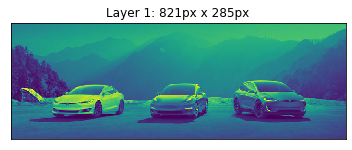

In [ ]:
# load test image
test_img = cv2.cvtColor(cv2.imread("test.jpg"), cv2.COLOR_BGR2GRAY)

# iterate through the scale-space pyramid on this image
for idx, layer in enumerate(pyramid(test_img)):
    # show the layer
    plt.imshow(layer)
    plt.title("Layer {}: {}px x {}px".format(idx + 1, layer.shape[1], layer.shape[0]))
    plt.xticks([]), plt.yticks([])
    plt.show()
    
    # iterate through the different window sizes and "strides" (how far the window jumps each step)
    window_sizes = {128, 100, 80, 60, 40}
    strides = {16, 8, 4, 2, 1}
    
    for w in window_sizes:
        for s in strides:
            for x, y, window in sliding_window(layer, stepSize=s, windowSize=(w, w)):
                # if the window does not meet our desired window size, we've overlapped an edge of the image
                    # ignore this window
                if window.shape[0] != w or window.shape[1] != w:
                    continue

                # perform HoG on the window (resized to 128 x 128)
                hog_feature_map = hog(cv2.resize(window, (128, 128)))
                
                # calculate the Euclidian distance between this window's HoG and the mean HoG of the training images
                euclidian_dist = np.linalg.norm(hog_feature_map - mean_feat_vec)
                euclidian_dist_flipped = np.linalg.norm(hog_feature_map - flipped_mean_feat_vec)
                
                # threshold the Euclidian distances to detect cars in the test image
                threshold = 15  # TODO vary this to maximize accuracy
                if euclidian_dist < threshold:
                    # if the Euclidian distance is better than our threshold, display the window on top of the image
                    clone = layer.copy()
                    cv2.rectangle(clone, (x, y), (x + w, y + w), (0, 255, 0), 2)
                    plt.imshow(clone)
                    plt.title("Car Detected (threshold = {})".format(threshold)), plt.xticks([]), plt.yticks([])
                    plt.show()
                    
                if euclidian_dist_flipped < threshold:
                    # if the Euclidian distance is better than our threshold, display the window on top of the image
                    clone = cv2.flip(layer, 0)
                    cv2.rectangle(clone, (x, y), (x + w, y + w), (0, 255, 0), 2)
                    plt.imshow(clone)
                    plt.title("Car Detected (threshold = {})".format(threshold)), plt.xticks([]), plt.yticks([])
                    plt.show()